# Generation

In [ ]:
import os
import re
import copy
import random
from collections import defaultdict
from itertools import groupby
from dataclasses import dataclass
from typing import List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D
from scipy.io.wavfile import write
from scipy.interpolate import make_interp_spline, Akima1DInterpolator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture

import librosa
import librosa.display
import soundfile as sf
from tqdm import tqdm
from dtw import dtw
from pydub import AudioSegment, silence
from pydub.generators import Sine
from pydub.playback import play
from praatio import tgio

import IPython.display as ipd
from IPython.display import display, clear_output
import ipywidgets as widgets

import utils2
import expressiveness_measure_new
import genetic_algo
from pitch_utilities import *
from constants import *

import Levenshtein
from Levenshtein import distance as levenshtein_distance

import modusa as ms



Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/Users/yashbhake/Desktop/MIR/ipynb notebooks/mirenv1/lib/python3.10/site-packages/praatio/utilities/utils.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


Constants

In [2]:
parent_dir = os.path.dirname(os.getcwd())
base_folder = os.path.join(parent_dir, 'All_audio_files_16kHz')
bandish_db = os.path.join(base_folder, 'bandish_database.xlsx')    


In [3]:
def get_song_artist_mapping(root_folder):
    song_artist_dict = {} 
    for song_folder in os.listdir(root_folder):
        song_path = os.path.join(root_folder, song_folder)
        if os.path.isdir(song_path):
            # Collect artist folders inside each song folder
            artists = [artist for artist in os.listdir(song_path) if os.path.isdir(os.path.join(song_path, artist))]
            song_artist_dict[song_folder] = artists
    
    return song_artist_dict

options = get_song_artist_mapping(base_folder)

folder_dropdown = widgets.Dropdown(options=options.keys(), description="Folder:")
artist_dropdown = widgets.Dropdown(description="Artist:")
fetch_button = widgets.Button(description="Get Files")
output = widgets.Output()

files = []  # Declare files variable outside
folder_artist = []

def update_artist_dropdown(change):
    artist_dropdown.options = options[change['new']]

folder_dropdown.observe(update_artist_dropdown, names='value')

def get_file_paths(b):
    global files  # Refer to the global files variable
    with output:
        clear_output()
        folder, artist = folder_dropdown.value, artist_dropdown.value
        folder_artist.append(folder)
        folder_artist.append(artist)
        artist_folder = os.path.join(base_folder, folder, artist)
        prefix = f"{'ja_jare' if 'ja_jare' in folder else 'yeri_aali'}_{artist}"
        files = [os.path.join(artist_folder, f).replace("\\", "/") for f in os.listdir(artist_folder) if f.startswith(prefix)]
        print(f"Files in {folder}/{artist}:\n" + "\n".join(files))


fetch_button.on_click(get_file_paths)


display(folder_dropdown, artist_dropdown, fetch_button, output)
update_artist_dropdown({'new': folder_dropdown.value})  # Initialize dropdown


Dropdown(description='Folder:', options=('yaman_yeri_aali', 'puriya_dhanashree_payaliya_jhankar', 'bhimpalasi_…

Dropdown(description='Artist:', options=(), value=None)

Button(description='Get Files', style=ButtonStyle())

Output()

In [4]:
if folder_artist ==[]: 
    folder_artist = ['bhimpalasi_ja_jare', 'ABD']
folder, artist = folder_artist[0], folder_artist[1]
bandish = folder.split('_', 1)[1] 
# tonic = get_tonic_from_excel(bandish_db, file_name, bandish)
# tonic_freq = get_frequency(tonic)

file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
file_name

'ja_jare_ABD'

In [5]:
def get_resampled_segments(y, tonic_freq, manual_onsets_plot, manual_dict, syl_id_dict, allotted_beats, note_cents_eq, syllable, bins=10):
    f0_praat_cents, times, unvoiced_intervals = pitch_contour_extrn1(y, SR, tonic_freq, CONTROLS, note_cents_eq)

    quantized_pitch_contour = quantize_pitch_contour(f0_praat_cents, note_cents_eq)
    syllable_segments, start_stamps, stop_stamps = get_syllable_PCs(manual_onsets_plot, manual_dict, f0_praat_cents, syl_id_dict, syllable, SR_NOV)
    
    n_bins = allotted_beats[syllable]*bins
    resampled_segments = []

    for currIndex, segment in enumerate(syllable_segments):
        quantized_segment = quantize_pitch_contour(segment, note_cents_eq)
        resampled_segment = resample_to_bins(quantized_segment.astype("str"), n_bins)
        resampled_segment = replace_infs(resampled_segment)
        resampled_segments.append(resampled_segment)
    return resampled_segments

def synthesize_sequences(sequences, durations, tonic_freq=261.63, sr=16000, mark_onsets=True):
    """
    Given a list of cent sequences and durations, generate one smooth waveform.
    Optionally insert a sharp high-pitch tone at the start of each segment to mark syllable onsets.
    Returns:
        full_waveform: synthesized audio
        full_time: timeline of pitch contour
        beep_times: np.array of beep timestamps (rounded to 2 decimals)
    """
    all_waveform = []
    all_time = []
    total_time = 0.0
    beep_times = []

    # onset beep parameters
    beep_freq = 5000        # Hz (high-pitch)
    beep_duration = 0.02    # 20 ms
    beep_len = int(beep_duration * sr)
    t_beep = np.arange(beep_len) / sr
    onset_beep = 0.8 * np.sin(2 * np.pi * beep_freq * t_beep) * np.hanning(beep_len)

    for i, (cents_vector, dur) in enumerate(zip(sequences, durations)):
        if dur <= 0:  # skip invalid durations
            continue

        contour, t = generate_pitch_contour(cents_vector, tonic_freq, dur, sr)
        waveform = synthesize_from_contour(contour, sr)

        # Add sharp onset beep at the start
        if mark_onsets:
            L = min(len(waveform), len(onset_beep))
            waveform[:L] += onset_beep[:L]
            beep_times.append(round(total_time, 2))  # record absolute onset time

        all_waveform.append(waveform)
        all_time.append(t + total_time)
        total_time += dur

    # Concatenate
    full_waveform = np.concatenate(all_waveform)
    full_time = np.concatenate(all_time)

    # Normalize final audio
    full_waveform = full_waveform / np.max(np.abs(full_waveform))

    return full_waveform, full_time, np.array(beep_times)



In [6]:
files = utils2.get_file_paths(base_folder, folder, artist)
audio_file = next((f for f in files if os.path.basename(f) == file_name+"_trimmed_gaudiolab_vocal.wav"), None)
if audio_file is None: raise FileNotFoundError(f"{file_name+'_trimmed_gaudiolab_vocal.wav'} not found in {files}")

y, sr = librosa.load(audio_file, sr=None)   
observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, allotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)
note_indices, note_cents_eq, syl_list, id_list, syl_id_dict = get_bandish_notes(bandish)
num_line_repetitions = 3
seq_id_list = id_list*num_line_repetitions
seq_id_list.append(id_list[0])

syl_labels_eng = [ENG_DICT[syl_id_dict[i]] for i in seq_id_list]

ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s


In [7]:
def create_new_sequences(folder, artist, num_line_repetitions, fitness_weights, generations, bpm=None, tonic=None, exp_tim_temp=1, bins=10, plot=True):
    files = utils2.get_file_paths(base_folder, folder, artist)
    bandish = folder.split('_', 1)[1] 
    file_name = f"{bandish}_{artist}"
    tonic = get_tonic_from_excel(bandish_db, file_name, bandish)
    tonic_freq = get_frequency(tonic)

    audio_file = next((f for f in files if os.path.basename(f) == file_name+"_trimmed_gaudiolab_vocal.wav"), None)
    if audio_file is None: raise FileNotFoundError(f"{file_name+'_trimmed_gaudiolab_vocal.wav'} not found in {files}")
   
    y, sr = librosa.load(audio_file, sr=None)   
    observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, allotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)
    note_indices, note_cents_eq, syl_list, id_list, syl_id_dict = get_bandish_notes(bandish)
    vocab = note_cents_eq
    observations_per_id = merge_by_syllable_first_key(observations_per_id, id_list, syl_list) 
    manual_dict = dict(zip(manual_onsets_plot, manual_labels_plot))
    frn_dev_lists = {}
    for syllable in id_list:
        frn_dev_list = get_syl_devns(observations_per_id, syllable)
        frn_dev_lists[syllable] = frn_dev_list

    seq_id_list = id_list*num_line_repetitions
    seq_id_list.append(id_list[0])

    deviations = []
    new_sequences = []

    beat_positions = []
    if bpm is None: bpm = mpm
    beat_duration = 60/bpm
    sum = 0
    syl_durations = []
    for index, id in enumerate(seq_id_list):
        beat_positions.append(sum*beat_duration)
        sum += allotted_beats[id]
        new_sample_dev = sample_from_gmm(frn_dev_lists[syllable], max_components=5)
        if index<1:
            new_sample_dev*=exp_tim_temp
            beat_positions[-1]+=new_sample_dev*beat_duration
        else:
            while (beat_positions[-1]+new_sample_dev*beat_duration)-beat_positions[-2] < 0.3*allotted_beats[seq_id_list[index-1]]*beat_duration:
                new_sample_dev = sample_from_gmm(frn_dev_lists[syllable], max_components=5)
            new_sample_dev*=exp_tim_temp
            beat_positions[-1]+=new_sample_dev*beat_duration
            durn = beat_positions[-1]-beat_positions[-2] 
            syl_durations.append(durn)

            syllable = seq_id_list[index-1]
            resampled_segments = get_resampled_segments(y, tonic_freq, manual_onsets_plot, manual_dict, syl_id_dict, allotted_beats, note_cents_eq, syllable, bins=bins)
            subsMat, mean_NLSS = NLSS_matrix(resampled_segments)
            resampled_segments = [[int(float(i)) if i!='-inf' else float(i) for i in segment] for segment in resampled_segments]

            ga = genetic_algo.GeneticAlgorithm(
                # duration = durn,
                original_contours=resampled_segments,
                vocabulary=vocab,
                population_size=int(len(resampled_segments)*2),
                generations=generations,
                mutation_rate=0.5*mean_NLSS,      
                tournament_size=3,
                fitness_weights=fitness_weights
            )

            evolved_contours = ga.run(previous_contour=new_sequences[-1] if len(new_sequences)>0 else None)
            new_seq = evolved_contours[0]
            new_sequences.append(new_seq)  # Placeholder: use first segment directly
    print(syl_durations)
    new_tonic = tonic if tonic is not None else "C#4"
    try:
        new_tonic_freq = get_frequency(new_tonic)
    except:
        print(f"Tonic {new_tonic} not found in frequency dictionary. Using default 277.18 Hz (C#4).")
        new_tonic_freq = 277.18
    waveform, times, beep_stamps = synthesize_sequences(new_sequences, syl_durations, tonic_freq=new_tonic_freq, sr=SR)

    

    # Plot
    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(times, waveform)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title("Joined Synthesized Pitch Contour")
        plt.show()
        

    # Save
    sf.write("generated_pitch_contour.wav", waveform, SR)
    return new_sequences, deviations, syl_durations, waveform, times, beep_stamps

    


ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s
[[np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('300.0'), np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('200.0')], [np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('200.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np

Evolving: 100%|██████████| 10/10 [00:00<00:00, 24.32it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), 

Evolving: 100%|██████████| 10/10 [00:00<00:00, 29.21it/s]


✅ Evolution complete!
[[np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0

Evolving: 100%|██████████| 10/10 [00:00<00:00, 29.71it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('3

Evolving: 100%|██████████| 10/10 [00:00<00:00, 60.16it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'),

Evolving: 100%|██████████| 10/10 [00:00<00:00, 79.70it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0')], [np.str_(

Evolving: 100%|██████████| 10/10 [00:00<00:00, 48.60it/s]


✅ Evolution complete!
[[np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-300.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('500.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0'), np.str_('700.0'), np.str_('500.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.st

Evolving: 100%|██████████| 10/10 [00:00<00:00, 31.26it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('1000.0'), np.str_('1000.0'), np.str_('1000.0'), np.str_('1000.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('900.0'), np.str_('1000.0'), np.str_('1000.0'), np.str

Evolving: 100%|██████████| 10/10 [00:00<00:00, 39.93it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700

Evolving: 100%|██████████| 10/10 [00:00<00:00, 41.23it/s]


✅ Evolution complete!
[[np.str_('900.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), 

Evolving: 100%|██████████| 10/10 [00:00<00:00, 34.62it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('300.0'), np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('200.0')], [np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('200.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np.str_('1000.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.

Evolving: 100%|██████████| 10/10 [00:00<00:00, 22.94it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), 

Evolving: 100%|██████████| 10/10 [00:00<00:00, 29.79it/s]


✅ Evolution complete!
[[np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0

Evolving: 100%|██████████| 10/10 [00:00<00:00, 27.27it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('3

Evolving: 100%|██████████| 10/10 [00:00<00:00, 59.69it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'),

Evolving: 100%|██████████| 10/10 [00:00<00:00, 73.36it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0')], [np.str_(

Evolving: 100%|██████████| 10/10 [00:00<00:00, 103.17it/s]


✅ Evolution complete!
[[np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-300.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('500.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0'), np.str_('700.0'), np.str_('500.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.st

Evolving: 100%|██████████| 10/10 [00:00<00:00, 28.27it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('1000.0'), np.str_('1000.0'), np.str_('1000.0'), np.str_('1000.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('900.0'), np.str_('1000.0'), np.str_('1000.0'), np.str

Evolving: 100%|██████████| 10/10 [00:00<00:00, 45.47it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700

Evolving: 100%|██████████| 10/10 [00:00<00:00, 45.47it/s]


✅ Evolution complete!
[[np.str_('900.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), 

Evolving: 100%|██████████| 10/10 [00:00<00:00, 35.23it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('300.0'), np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('200.0')], [np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('200.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('700.0'), np.str_('700.0'), np.str_('1000.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.

Evolving: 100%|██████████| 10/10 [00:00<00:00, 24.09it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), 

Evolving: 100%|██████████| 10/10 [00:00<00:00, 30.56it/s]


✅ Evolution complete!
[[np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0

Evolving: 100%|██████████| 10/10 [00:00<00:00, 31.27it/s]


✅ Evolution complete!
[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('200.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('300.0'), np.str_('200.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('300.0'), np.str_('200.0'), np.str_('3

Evolving: 100%|██████████| 10/10 [00:00<00:00, 53.94it/s]

✅ Evolution complete!


[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np

Evolving: 100%|██████████| 10/10 [00:00<00:00, 85.31it/s]

✅ Evolution complete!


[[np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0')], [np.str_('0.0'), np.str_('0.0')

Evolving: 100%|██████████| 10/10 [00:00<00:00, 48.27it/s]


✅ Evolution complete!
[[np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-300.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-200.0'), np.str_('-300.0'), np.str_('-200.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('500.0')], [np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('0.0'), np.str_('200.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0'), np.str_('700.0'), np.str_('500.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.st

Evolving: 100%|██████████| 10/10 [00:00<00:00, 31.76it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('1000.0'), np.str_('1000.0'), np.str_('1000.0'), np.str_('1000.0'), np.str_('900.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('900.0'), np.str_('1000.0'), np.str_('1000.0'), np.str

Evolving: 100%|██████████| 10/10 [00:00<00:00, 40.04it/s]


✅ Evolution complete!
[[np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700

Evolving: 100%|██████████| 10/10 [00:00<00:00, 42.49it/s]


✅ Evolution complete!
[[np.str_('900.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0')], [np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('500.0')], [np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('700.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('500.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), np.str_('300.0'), 

Evolving: 100%|██████████| 10/10 [00:00<00:00, 34.31it/s]


✅ Evolution complete!
[0.7789465867676719, 0.8081066383008952, 1.0080763845568743, 0.2998488860417585, 0.25353665861227404, 0.8572195561455729, 0.7878958623056329, 0.5214340218185427, 0.40286861616582037, 0.704770426732507, 0.7527961943693393, 0.8455161213655131, 0.9531274961567409, 0.3016132797596409, 0.300209008806684, 0.8118629512905446, 0.8245963994274703, 0.6072335885863964, 0.27762943348792213, 0.7336156179652935, 0.7587297966480815, 0.8137605559616468, 0.9966317702202101, 0.2826121401051367, 0.29144856597062585, 0.8036054128762871, 0.8342203727288044, 0.517974839020205, 0.20550557635921862, 0.8897708740515178]


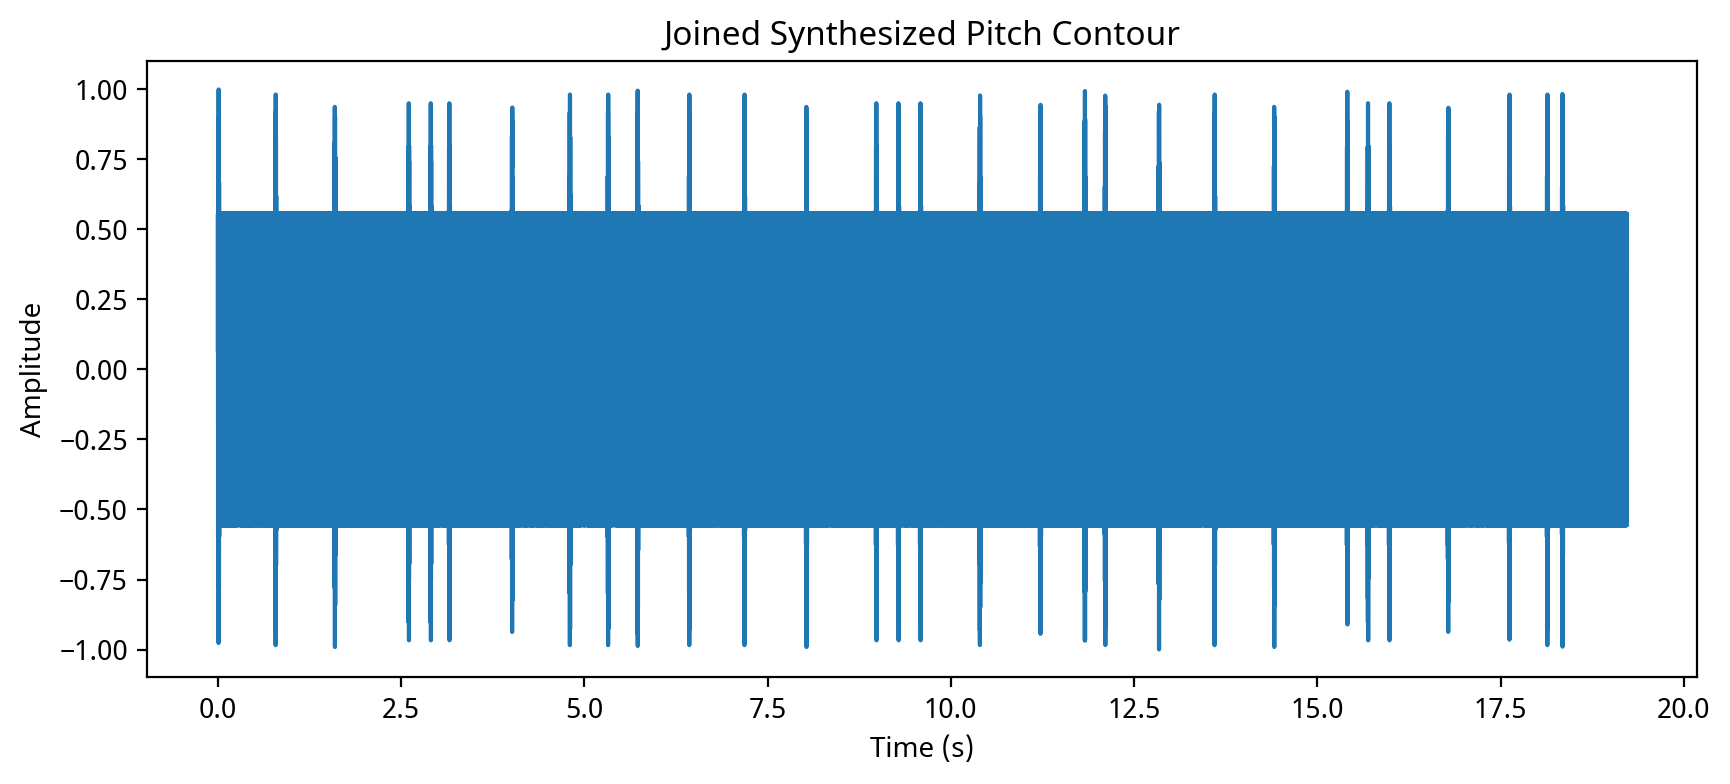

In [8]:
num_line_repetitions = 3
bpm = 150
tabla_softness_db = -5
fitness_weights = (0.4, 0.4, 0.2)
folder = 'bhimpalasi_ja_jare'
artist = 'ABD'
tonic = "A#4"
bins = 10
exp_tim_temp = 0.5
plot=True
generations = 10
new_sequences, deviations, syl_durations, waveform, times, beep_stamps = create_new_sequences(folder, artist, num_line_repetitions, fitness_weights, generations, bpm=bpm, tonic=tonic, exp_tim_temp=exp_tim_temp, bins=bins, plot=plot)

### with tabla

In [9]:
# Your target BPM (from variable 'bpm')
target_bpm = bpm   # e.g. 150

# Step 1: Load tabla separately with librosa for time-stretching
y, sr = librosa.load("tabla_teental_120bpm.wav", sr=None)

# Original tabla BPM
orig_bpm = 120

# Stretch factor
stretch_factor = target_bpm / orig_bpm

# Apply time-stretching (preserves pitch)
y_stretched = librosa.effects.time_stretch(y, rate=stretch_factor)

# Save temporary file for pydub
sf.write("tabla_stretched.wav", y_stretched, sr)

# Step 2: Now use pydub for alignment/mixing
tabla = AudioSegment.from_file("tabla_stretched.wav")
output = AudioSegment.from_file("generated_pitch_contour.wav")

# Make the tabla softer
tabla = tabla.apply_gain(-5)

# Trim tabla to match output length + 3 sec offset
tabla = tabla[:len(output) + 6000*60/bpm]

# Add 3 sec silence before output
output = AudioSegment.silent(duration=6000*60/bpm) + output

# Mix tabla with shifted output
final = tabla.overlay(output)

# Export final result
final.export("generated_final.wav", format="wav")


<_io.BufferedRandom name='generated_final.wav'>

In [10]:
import numpy as np

def generate_teentaal_beats(bpm, total_time):
    """
    Generate a list of (timestamp, label) for teentaal beats within total_time.
    
    Args:
        bpm (float): tempo in beats per minute
        total_time (float): total duration in seconds

    Returns:
        np.ndarray: array of shape (N, 2), with [timestamp, label]
    """
    beat_dur = 60.0 / bpm
    n_beats = int(total_time / beat_dur) + 1

    beats = []
    for i in range(n_beats):
        t = round(i * beat_dur, 2)
        beat_in_cycle = (i % 16) + 1  # 1 to 16
        if beat_in_cycle == 1:
            label = "x"
        elif beat_in_cycle == 9:
            label = "o"
        else:
            label = ""
        beats.append((t, label))

    return np.array(beats, dtype=object)



In [11]:
beats = generate_teentaal_beats(bpm=bpm, total_time=len(final)/1000)

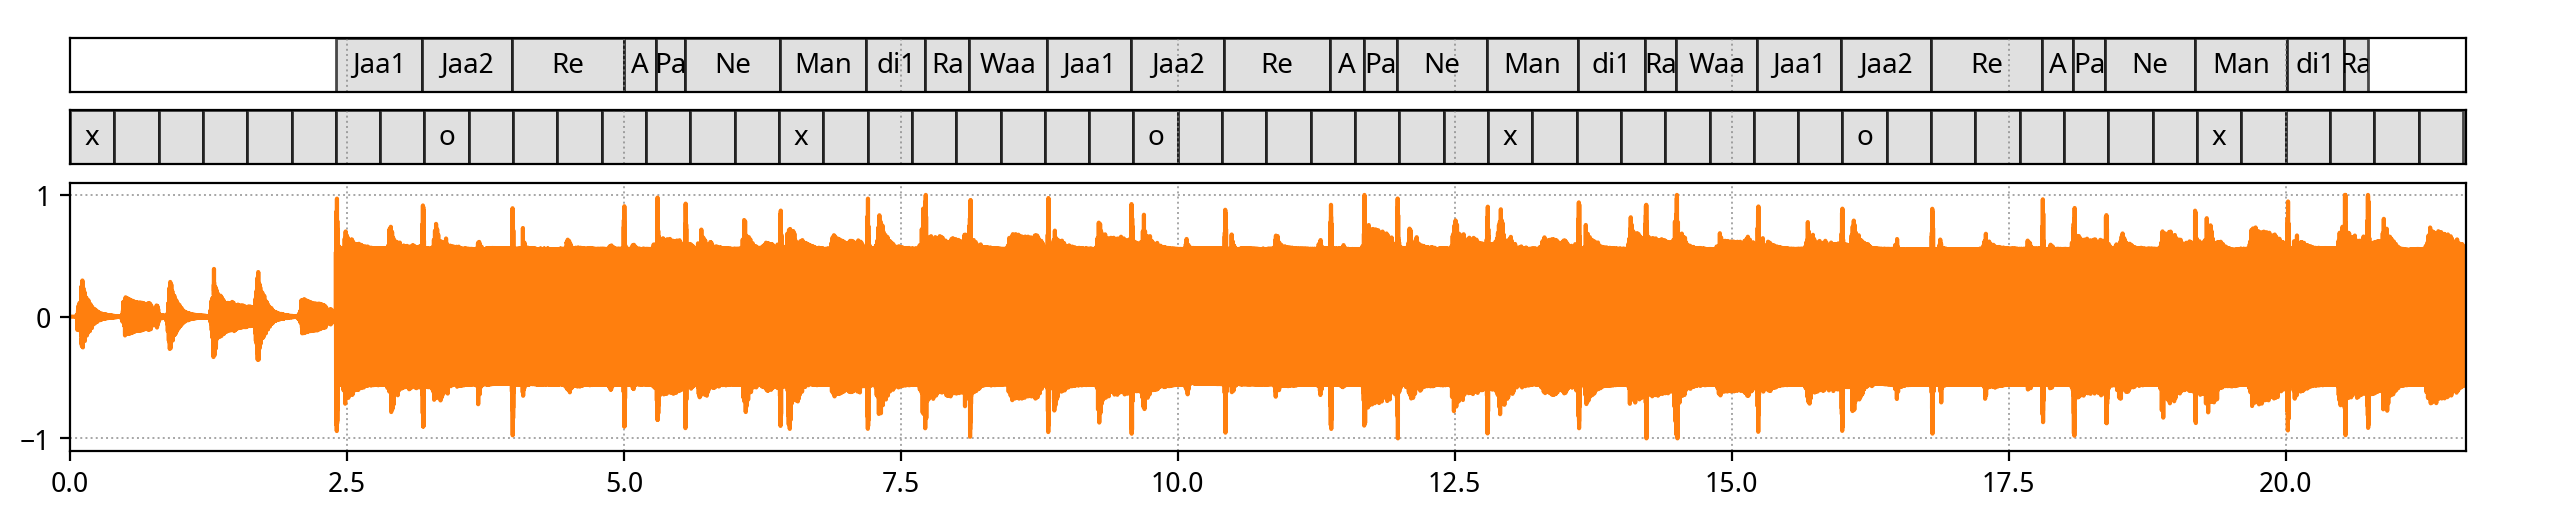

In [19]:
fig = ms.fig("aas", xlim=(0, len(final)/1000))
fig.add_annotation([(6*60/bpm + beep_stamps[i], 6*60/bpm + beep_stamps[i+1], lab) for i, lab in enumerate(syl_labels_eng) if i<=len(syl_labels_eng)-3])
fig.add_annotation([(beats[i][0], beats[i+1][0], beats[i][1]) for i in range(len(beats)-1)])
y, sr = librosa.load("generated_final.wav", sr=None)
times = np.arange(len(y)) / sr
fig.add_signal(y, times)

